<a href="https://www.kaggle.com/code/davidpbriggs/notebook-flights-to-italy?scriptVersionId=227966042" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Flights to Italy: Data Exploration & Analysis
In this notebook, we perform data exploration and analysis on a series of flights between UK and Italy. We compile the flight tracking data and summarise flight information to create additional visualisations in [Tableau](https://public.tableau.com/views/FlightstoItaly/Dashboard1).

## Step 1: Imports
We import relevant Python packages to clean, explore and analyse the data.

In [1]:
# Import libraries and packages
import pandas as pd
import numpy as np
import glob
import os
import re
from scipy.spatial import cKDTree

import seaborn as sns
import matplotlib.pyplot as plt

We load the **World_Airports** dataset into a pandas DataFrame and store it in the variable **world_airports**.

In [2]:
# Import airport data
world_airports = pd.read_csv('../input/world-airports/World_Airports.csv')

We compile a list of CSV files containing flight tracking data from the *flights-to-italy* folder, then load and merge them into a single pandas DataFrame called **combined_df**, adding a column named **Source_File** to record the filename for each dataset.

In [3]:
# Define the directory containing the CSV files
dirname = '../input/flights-to-italy'

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(dirname, "*.csv"))

# Read all CSV files, adding a column for the filename
df_list = [pd.read_csv(file).assign(Source_File=(os.path.basename(file))) for file in csv_files]

# Concatenate list into one DataFrame
combined_df = pd.concat(df_list, ignore_index=True)


## Step 2: Data Exploration & Data Cleaning
### Flight tracking data

We check the number of flight tracking CSV files used to compile the **combined_df** DataFrame, which corresponds to the total number of flights.

In [4]:
len(csv_files)

103

We display the first 10 rows of the **combined_df** DataFrame.

In [5]:
combined_df.head()

,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction,Source_File
0,1704620994,2024-01-07T09:49:54Z,WMT7480,"51.155273,-0.167226",0,0,348,31 W45781_3387f3d0.csv
1,1704621092,2024-01-07T09:51:32Z,WMT7480,"51.155067,-0.167152",0,2,348,31 W45781_3387f3d0.csv
2,1704621114,2024-01-07T09:51:54Z,WMT7480,"51.154858,-0.167122",0,2,337,31 W45781_3387f3d0.csv
3,1704621136,2024-01-07T09:52:16Z,WMT7480,"51.154648,-0.167046",0,2,306,31 W45781_3387f3d0.csv
4,1704621159,2024-01-07T09:52:39Z,WMT7480,"51.154495,-0.166836",0,1,270,31 W45781_3387f3d0.csv


In [6]:
combined_df.describe()

,Timestamp,Altitude,Speed,Direction
count,5.937700e+04,59377.000000,59377.000000,59377.000000
mean,1.709201e+09,13811.056049,239.005659,204.715024
std,2.205071e+07,14863.083690,171.061242,97.385447
min,1.653399e+09,0.000000,0.000000,1.000000
25%,1.697446e+09,0.000000,25.000000,128.000000
50%,1.712059e+09,6875.000000,246.000000,188.000000
75%,1.727682e+09,33875.000000,409.000000,303.000000
max,1.740386e+09,39075.000000,587.000000,360.000000


This suggests that the **Altitude** is measured *feet* from ground level and the **Speed** of the aircraft is measured in *km/h*.

We check the data types of all columns in the combined flight tracking DataFrame.
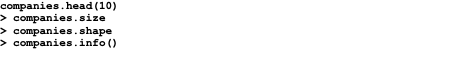
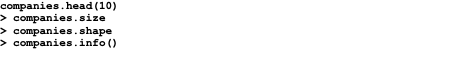
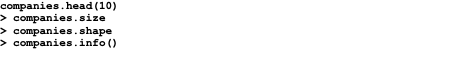
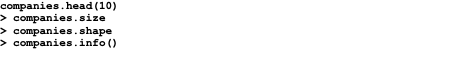

In [7]:
# Check datatypes
combined_df.dtypes

Timestamp       int64
UTC            object
Callsign       object
Position       object
Altitude        int64
Speed           int64
Direction       int64
Source_File    object
dtype: object

We convert the **UTC** column to a pandas *datetime64* type for easier time-based analysis.

In [8]:
# Convert UTC column to datetime
combined_df['UTC']  = pd.to_datetime(combined_df['UTC'])

# Re-check datatypes
combined_df.dtypes

Timestamp                    int64
UTC            datetime64[ns, UTC]
Callsign                    object
Position                    object
Altitude                     int64
Speed                        int64
Direction                    int64
Source_File                 object
dtype: object

We check for missing values in the DataFrame.

In [9]:
# Check for missing values
combined_df.isnull().sum()

Timestamp      0
UTC            0
Callsign       0
Position       0
Altitude       0
Speed          0
Direction      0
Source_File    0
dtype: int64

We remove rows with missing values and store the resulting DataFrame in the variable **subset_df**.

In [10]:
# Drop rows that contain missing values
subset_df = combined_df.dropna(axis=0)

# Re-check for missing values
subset_df.isnull().sum()

Timestamp      0
UTC            0
Callsign       0
Position       0
Altitude       0
Speed          0
Direction      0
Source_File    0
dtype: int64

We check the DataFrame for duplicate entries.

In [11]:
# Check the shape of the dataframe
subset_df.shape

(59377, 8)

In [12]:
# Drop duplicates
subset_df.drop_duplicates().reset_index(drop=True)

# Re-Check the shape of the dataframe
subset_df.shape

(59377, 8)

We extract the **Latitude** and **Longitude** values from the **Position** column and convert them to numeric types.

In [13]:
# Add new columns for latitude and longitude
#combined_df['Latitude'] = 
#combined_df['Longitude'] = 
# Split the 'position' column into two new columns: 'latitude' and 'longitude'
subset_df[['Latitude', 'Longitude']] = subset_df['Position'].str.split(',', expand=True)

# Convert the latitude and longitude columns to numeric types
subset_df['Latitude'] = pd.to_numeric(subset_df['Latitude'])
subset_df['Longitude'] = pd.to_numeric(subset_df['Longitude'])

subset_df.head()

,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction,Source_File,Latitude,Longitude
0,1704620994,2024-01-07 09:49:54+00:00,WMT7480,"51.155273,-0.167226",0,0,348,31 W45781_3387f3d0.csv,51.155273,-0.167226
1,1704621092,2024-01-07 09:51:32+00:00,WMT7480,"51.155067,-0.167152",0,2,348,31 W45781_3387f3d0.csv,51.155067,-0.167152
2,1704621114,2024-01-07 09:51:54+00:00,WMT7480,"51.154858,-0.167122",0,2,337,31 W45781_3387f3d0.csv,51.154858,-0.167122
3,1704621136,2024-01-07 09:52:16+00:00,WMT7480,"51.154648,-0.167046",0,2,306,31 W45781_3387f3d0.csv,51.154648,-0.167046
4,1704621159,2024-01-07 09:52:39+00:00,WMT7480,"51.154495,-0.166836",0,1,270,31 W45781_3387f3d0.csv,51.154495,-0.166836


We extract the **Flight Number** from the filename stored in the **Source_File** column.

In [14]:
# Extract Flight Number from filename
subset_df['Flight_Number'] = subset_df['Source_File'].str.extract(r' (\S+)_', expand=False)
subset_df.head()

,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction,Source_File,Latitude,Longitude,Flight_Number
0,1704620994,2024-01-07 09:49:54+00:00,WMT7480,"51.155273,-0.167226",0,0,348,31 W45781_3387f3d0.csv,51.155273,-0.167226,W45781
1,1704621092,2024-01-07 09:51:32+00:00,WMT7480,"51.155067,-0.167152",0,2,348,31 W45781_3387f3d0.csv,51.155067,-0.167152,W45781
2,1704621114,2024-01-07 09:51:54+00:00,WMT7480,"51.154858,-0.167122",0,2,337,31 W45781_3387f3d0.csv,51.154858,-0.167122,W45781
3,1704621136,2024-01-07 09:52:16+00:00,WMT7480,"51.154648,-0.167046",0,2,306,31 W45781_3387f3d0.csv,51.154648,-0.167046,W45781
4,1704621159,2024-01-07 09:52:39+00:00,WMT7480,"51.154495,-0.166836",0,1,270,31 W45781_3387f3d0.csv,51.154495,-0.166836,W45781


We use the *Haversine formula* to compute the **Distance** between each longitude/latitude position when the plane is airborne (ie. **Altitude** > 0), measured in *kilometres*.

In [15]:
# Haversine formula to calculate the distance between two latitutde/longitude points
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in km
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    return distance

# Calculate the distance between consecutive points and sum them
subset_df['Distance'] = 0.0  # Initialise the distance column

# Loop through the rows and calculate distance for each pair of consecutive points
for i in range(1, len(subset_df)):
    lat1 = subset_df.iloc[i-1]['Latitude']
    lon1 = subset_df.iloc[i-1]['Longitude']
    lat2 = subset_df.iloc[i]['Latitude']
    lon2 = subset_df.iloc[i]['Longitude']

    altitude1 = subset_df.iloc[i-1]['Altitude']
    altitude2 = subset_df.iloc[i]['Altitude']

    # check if altitude greater than zero before calculating distance
    if altitude1 > 0 and altitude2 > 0:
        # Calculate distance between consecutive points and add to the 'Distance' column
        subset_df.at[i, 'Distance'] = haversine(lat1, lon1, lat2, lon2)


We calculate the total distance traveled for each flight.

In [16]:
# Calculate flight distance
flight_distances = subset_df[['Source_File', 'Distance']].groupby('Source_File', as_index=False).sum('Distance')
flight_distances.head()

,Source_File,Distance
0,12 VY6225_2bfa6a2f.csv,1496.086917
1,12 VY6309_2c1b7198.csv,1474.903599
2,13 U28258_2c767cc3.csv,1442.235874
3,13 W65781_2c4ead8b.csv,1501.158745
4,14 U26553_2cde6a10.csv,1912.773871


Check flight distance estimates look plausible.

In [17]:
# Review flight distance estimates
flight_distances = flight_distances.sort_values(by='Distance', ascending=False)
print(flight_distances)

               Source_File     Distance
74  47 U28282_366f1e73.csv  1967.684568
23  22 U28333_319c5725.csv  1933.711774
4   14 U26553_2cde6a10.csv  1912.773871
5   14 U26554_2cf6cbec.csv  1854.525158
75  48 BA2607_36a78b46.csv  1844.492159
..                     ...          ...
46  33 W45781_34252ac3.csv  1442.226161
6   15 AF1005_2e592556.csv  1132.525120
22   22 AZ220_319e2397.csv  1033.308678
21  22 AZ1642_319d4dd5.csv   897.762691
19  21 U28326_3048a2c4.csv   172.988768

[103 rows x 2 columns]


### Summary Flight Information
We create a second DataFrame, **summary_flight_info**, to store summary information for each flight. This includes the latitude, longitude, and time for both the start and finish positions of the aircraft, as well as the take-off and landing times.

In [18]:
# Compile list of flights
list_of_flights = subset_df['Source_File'].unique().tolist()

# Initialise an empty list to store the summary data
summary_flight_info = list()

for filename in list_of_flights:
    # filter data for the current flight
    flight_data = subset_df[subset_df['Source_File'] == filename]
    
    # get start and finish latitude and longitude
    start_lat = flight_data.iloc[0]['Latitude']
    start_lon = flight_data.iloc[0]['Longitude']
    finish_lat = flight_data.iloc[-1]['Latitude']
    finish_lon = flight_data.iloc[-1]['Longitude']
    
    start_time = flight_data.iloc[0]['UTC']
    finish_time = flight_data.iloc[-1]['UTC']

    takeoff_time = flight_data[flight_data['Altitude'] > 0].iloc[0]['UTC']
    landing_time = flight_data[flight_data['Altitude'] > 0].iloc[-1]['UTC']
    
    # Create a summary dictionary for this flight
    summary = {
        'Source_File': filename,
        'Flight_Number': flight_data['Flight_Number'].iloc[0],
        'Start_Latitude': start_lat,
        'Start_Longitude': start_lon,
        'Finish_Latitude': finish_lat,
        'Finish_Longitude': finish_lon,
        'Start_UTC': start_time,
        'Finish_UTC': finish_time,
        'Take-off': takeoff_time,
        'Landing': landing_time
    }
    
    # Append the summary for this flight to the list
    summary_flight_info.append(summary)

# Convert the list of dictionaries to a DataFrame
summary_flight_info = pd.DataFrame(summary_flight_info)

summary_flight_info.head()

,Source_File,Flight_Number,Start_Latitude,Start_Longitude,Finish_Latitude,Finish_Longitude,Start_UTC,Finish_UTC,Take-off,Landing
0,31 W45781_3387f3d0.csv,W45781,51.155273,-0.167226,41.796593,12.257324,2024-01-07 09:49:54+00:00,2024-01-07 12:17:01+00:00,2024-01-07 10:06:20+00:00,2024-01-07 12:08:21+00:00
1,20 W65781_2fd730dd.csv,W65781,51.154835,-0.168591,41.797554,12.240705,2023-04-10 10:51:20+00:00,2023-04-10 13:19:35+00:00,2023-04-10 11:15:00+00:00,2023-04-10 13:07:13+00:00
2,18 VY6224_2f416ac8.csv,VY6224,41.796593,12.258261,51.155148,-0.168469,2023-02-19 16:13:09+00:00,2023-02-19 18:51:59+00:00,2023-02-19 16:40:55+00:00,2023-02-19 18:45:46+00:00
3,13 W65781_2c4ead8b.csv,W65781,51.159119,-0.168339,41.793365,12.247431,2022-06-19 11:09:57+00:00,2022-06-19 13:36:42+00:00,2022-06-19 11:30:36+00:00,2022-06-19 13:31:42+00:00
4,42 U28324_355fd7d4.csv,U28324,41.793621,12.246962,51.155243,-0.176296,2024-05-25 09:19:25+00:00,2024-05-25 12:13:27+00:00,2024-05-25 09:42:33+00:00,2024-05-25 12:06:50+00:00


We convert **Start_UTC**, **Finish_UTC**, **Take-off** and **Landing** to the pandas *datetime64* type.

In [19]:
# Convert date/time
summary_flight_info['Start_UTC']  = pd.to_datetime(summary_flight_info['Start_UTC'])
summary_flight_info['Finish_UTC'] = pd.to_datetime(summary_flight_info['Finish_UTC'])
summary_flight_info['Take-off']   = pd.to_datetime(summary_flight_info['Take-off'])
summary_flight_info['Landing']    = pd.to_datetime(summary_flight_info['Landing'])

summary_flight_info.head()

,Source_File,Flight_Number,Start_Latitude,Start_Longitude,Finish_Latitude,Finish_Longitude,Start_UTC,Finish_UTC,Take-off,Landing
0,31 W45781_3387f3d0.csv,W45781,51.155273,-0.167226,41.796593,12.257324,2024-01-07 09:49:54+00:00,2024-01-07 12:17:01+00:00,2024-01-07 10:06:20+00:00,2024-01-07 12:08:21+00:00
1,20 W65781_2fd730dd.csv,W65781,51.154835,-0.168591,41.797554,12.240705,2023-04-10 10:51:20+00:00,2023-04-10 13:19:35+00:00,2023-04-10 11:15:00+00:00,2023-04-10 13:07:13+00:00
2,18 VY6224_2f416ac8.csv,VY6224,41.796593,12.258261,51.155148,-0.168469,2023-02-19 16:13:09+00:00,2023-02-19 18:51:59+00:00,2023-02-19 16:40:55+00:00,2023-02-19 18:45:46+00:00
3,13 W65781_2c4ead8b.csv,W65781,51.159119,-0.168339,41.793365,12.247431,2022-06-19 11:09:57+00:00,2022-06-19 13:36:42+00:00,2022-06-19 11:30:36+00:00,2022-06-19 13:31:42+00:00
4,42 U28324_355fd7d4.csv,U28324,41.793621,12.246962,51.155243,-0.176296,2024-05-25 09:19:25+00:00,2024-05-25 12:13:27+00:00,2024-05-25 09:42:33+00:00,2024-05-25 12:06:50+00:00


We use the take-off and landing times to compute a new column, **Flight_Duration**, in the **summary_flight_info** DataFrame.

In [20]:
# Calculate Flight Duration
summary_flight_info['Flight_Duration'] = summary_flight_info['Landing'] - summary_flight_info['Take-off']
summary_flight_info.head()

,Source_File,Flight_Number,Start_Latitude,Start_Longitude,Finish_Latitude,Finish_Longitude,Start_UTC,Finish_UTC,Take-off,Landing,Flight_Duration
0,31 W45781_3387f3d0.csv,W45781,51.155273,-0.167226,41.796593,12.257324,2024-01-07 09:49:54+00:00,2024-01-07 12:17:01+00:00,2024-01-07 10:06:20+00:00,2024-01-07 12:08:21+00:00,0 days 02:02:01
1,20 W65781_2fd730dd.csv,W65781,51.154835,-0.168591,41.797554,12.240705,2023-04-10 10:51:20+00:00,2023-04-10 13:19:35+00:00,2023-04-10 11:15:00+00:00,2023-04-10 13:07:13+00:00,0 days 01:52:13
2,18 VY6224_2f416ac8.csv,VY6224,41.796593,12.258261,51.155148,-0.168469,2023-02-19 16:13:09+00:00,2023-02-19 18:51:59+00:00,2023-02-19 16:40:55+00:00,2023-02-19 18:45:46+00:00,0 days 02:04:51
3,13 W65781_2c4ead8b.csv,W65781,51.159119,-0.168339,41.793365,12.247431,2022-06-19 11:09:57+00:00,2022-06-19 13:36:42+00:00,2022-06-19 11:30:36+00:00,2022-06-19 13:31:42+00:00,0 days 02:01:06
4,42 U28324_355fd7d4.csv,U28324,41.793621,12.246962,51.155243,-0.176296,2024-05-25 09:19:25+00:00,2024-05-25 12:13:27+00:00,2024-05-25 09:42:33+00:00,2024-05-25 12:06:50+00:00,0 days 02:24:17


### World Airport Data
Finally, we explore the **World_Airports** DataFrame which we will use to identify the departure and arrival airport for each flight.

In [21]:
# Get the data types and number of non-null values in the dataset
world_airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75052 entries, 0 to 75051
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  75051 non-null  float64
 1   Y                  75051 non-null  float64
 2   OBJECTID           75052 non-null  int64  
 3   id                 75052 non-null  int64  
 4   airport_ident      75052 non-null  object 
 5   type               75052 non-null  object 
 6   name               75052 non-null  object 
 7   latitude_deg       75052 non-null  float64
 8   longitude_deg      75052 non-null  float64
 9   elevation_ft       60789 non-null  float64
 10  continent          38826 non-null  object 
 11  iso_country        74793 non-null  object 
 12  iso_region         75052 non-null  object 
 13  municipality       70060 non-null  object 
 14  scheduled_service  75052 non-null  object 
 15  gps_code           41172 non-null  object 
 16  iata_code          886

We create a subset of the DataFrame containing the required columns: airport name, latitude, longitude, and IATA code.

In [22]:
# Create subset of DataFrame with only the columns we require
subset_world_airports = world_airports[['name', 'latitude_deg', 'longitude_deg', 'iata_code']]

We check for missing values in the new DataFrame.

In [23]:
# Check for missing values
subset_world_airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75052 entries, 0 to 75051
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           75052 non-null  object 
 1   latitude_deg   75052 non-null  float64
 2   longitude_deg  75052 non-null  float64
 3   iata_code      8868 non-null   object 
dtypes: float64(2), object(2)
memory usage: 2.3+ MB


It appears that not all airports have IATA codes. We drop rows that contain missing values.

In [24]:
# Drop rows that contain missing values
subset_world_airports = subset_world_airports.dropna(axis=0)

# Reset the index
subset_world_airports = subset_world_airports.reset_index(drop=True)

# Check data types
subset_world_airports.shape

(8868, 4)

We check the DataFrame for duplicate entries.

In [25]:
# Check for duplicates
subset_world_airports.drop_duplicates().shape

(8868, 4)

We use *cKDTree*, an efficient spatial data structure, to identify the departure and arrival airports for each flight and add this information to the flight summary DataFrame.

In [26]:
# Departure Airport
# Extract airport coordinates
airport_coords = subset_world_airports[['latitude_deg', 'longitude_deg']].to_numpy()

# Build KDTree from airport coordinates
airport_tree = cKDTree(airport_coords)

# Extract flight start coordinates
flight_coords = summary_flight_info[['Start_Latitude', 'Start_Longitude']].to_numpy()

# Find nearest airport index
distances, indices = airport_tree.query(flight_coords)

# Add the nearest airport index to summary_flight_info
summary_flight_info['Nearest_Airport_Index'] = indices

# Merge back with airport details using the index
summary_flight_info_merged1 = summary_flight_info.merge(
    subset_world_airports[['name', 'iata_code']].reset_index(),
    left_on='Nearest_Airport_Index',
    right_index=True,
    how='left'
)

# Rename columns
summary_flight_info_merged1.rename(columns={'name': 'Departure_Airport', 'iata_code': 'Departure_IATA'}, inplace=True)

# Drop unnecessary columns
summary_flight_info_merged1.drop(columns=['Nearest_Airport_Index', 'index'], inplace=True)

In [27]:
# Arrival Airport
# Extract flight finish coordinates
flight_coords = summary_flight_info_merged1[['Finish_Latitude', 'Finish_Longitude']].to_numpy()

# Find nearest airport index
distances, indices = airport_tree.query(flight_coords)

# Add the nearest airport index to summary_flight_info
summary_flight_info_merged1['Nearest_Airport_Index'] = indices

# Merge back with airport details using the index
summary_flight_info_merged2 = summary_flight_info_merged1.merge(
    subset_world_airports[['name', 'iata_code']].reset_index(),
    left_on='Nearest_Airport_Index',
    right_index=True,
    how='left'
)

# Rename columns
summary_flight_info_merged2.rename(columns={'name': 'Arrival_Airport', 'iata_code': 'Arrival_IATA'}, inplace=True)

# Drop unnecessary columns
summary_flight_info_merged2.drop(columns=['Nearest_Airport_Index', 'index'], inplace=True)

summary_flight_info_merged2.head()

,Source_File,Flight_Number,Start_Latitude,Start_Longitude,Finish_Latitude,Finish_Longitude,Start_UTC,Finish_UTC,Take-off,Landing,Flight_Duration,Departure_Airport,Departure_IATA,Arrival_Airport,Arrival_IATA
0,31 W45781_3387f3d0.csv,W45781,51.155273,-0.167226,41.796593,12.257324,2024-01-07 09:49:54+00:00,2024-01-07 12:17:01+00:00,2024-01-07 10:06:20+00:00,2024-01-07 12:08:21+00:00,0 days 02:02:01,London Gatwick Airport,LGW,Rome–Fiumicino Leonardo da Vinci International...,FCO
1,20 W65781_2fd730dd.csv,W65781,51.154835,-0.168591,41.797554,12.240705,2023-04-10 10:51:20+00:00,2023-04-10 13:19:35+00:00,2023-04-10 11:15:00+00:00,2023-04-10 13:07:13+00:00,0 days 01:52:13,London Gatwick Airport,LGW,Rome–Fiumicino Leonardo da Vinci International...,FCO
2,18 VY6224_2f416ac8.csv,VY6224,41.796593,12.258261,51.155148,-0.168469,2023-02-19 16:13:09+00:00,2023-02-19 18:51:59+00:00,2023-02-19 16:40:55+00:00,2023-02-19 18:45:46+00:00,0 days 02:04:51,Rome–Fiumicino Leonardo da Vinci International...,FCO,London Gatwick Airport,LGW
3,13 W65781_2c4ead8b.csv,W65781,51.159119,-0.168339,41.793365,12.247431,2022-06-19 11:09:57+00:00,2022-06-19 13:36:42+00:00,2022-06-19 11:30:36+00:00,2022-06-19 13:31:42+00:00,0 days 02:01:06,London Gatwick Airport,LGW,Rome–Fiumicino Leonardo da Vinci International...,FCO
4,42 U28324_355fd7d4.csv,U28324,41.793621,12.246962,51.155243,-0.176296,2024-05-25 09:19:25+00:00,2024-05-25 12:13:27+00:00,2024-05-25 09:42:33+00:00,2024-05-25 12:06:50+00:00,0 days 02:24:17,Rome–Fiumicino Leonardo da Vinci International...,FCO,London Gatwick Airport,LGW


We add the previously calculated flight distance to the summary flight info Data Frame.

In [28]:
# Merge with summary flight info
summary_flight_info_merged3 = summary_flight_info_merged2.merge(
    flight_distances[['Source_File', 'Distance']],
    on='Source_File',
    how='inner'
)


We add a **Flight_Date** column.

In [29]:
summary_flight_info_merged3['Flight_Date']=summary_flight_info_merged3['Start_UTC'].dt.date

We estimate carbon emissions for each flight based on carbon intensity of [95 g CO2 / RPK](https://www.icao.int/Meetings/a40/Documents/WP/wp_560_rev1_en.pdf) (grammes of CO2 per Revenue Passenger Kilometers).

In [30]:
# Mean Flight Distance
mean_flight_distance = summary_flight_info_merged3['Distance'].max()

# Estimate Flight Carbon Emissions per passenger
summary_flight_info_merged3['CO2_Emissions'] = summary_flight_info_merged3['Distance'] * (95/1000)
summary_flight_info_merged3.head()


,Source_File,Flight_Number,Start_Latitude,Start_Longitude,Finish_Latitude,Finish_Longitude,Start_UTC,Finish_UTC,Take-off,Landing,Flight_Duration,Departure_Airport,Departure_IATA,Arrival_Airport,Arrival_IATA,Distance,Flight_Date,CO2_Emissions
0,31 W45781_3387f3d0.csv,W45781,51.155273,-0.167226,41.796593,12.257324,2024-01-07 09:49:54+00:00,2024-01-07 12:17:01+00:00,2024-01-07 10:06:20+00:00,2024-01-07 12:08:21+00:00,0 days 02:02:01,London Gatwick Airport,LGW,Rome–Fiumicino Leonardo da Vinci International...,FCO,1475.024254,2024-01-07,140.127304
1,20 W65781_2fd730dd.csv,W65781,51.154835,-0.168591,41.797554,12.240705,2023-04-10 10:51:20+00:00,2023-04-10 13:19:35+00:00,2023-04-10 11:15:00+00:00,2023-04-10 13:07:13+00:00,0 days 01:52:13,London Gatwick Airport,LGW,Rome–Fiumicino Leonardo da Vinci International...,FCO,1547.424643,2023-04-10,147.005341
2,18 VY6224_2f416ac8.csv,VY6224,41.796593,12.258261,51.155148,-0.168469,2023-02-19 16:13:09+00:00,2023-02-19 18:51:59+00:00,2023-02-19 16:40:55+00:00,2023-02-19 18:45:46+00:00,0 days 02:04:51,Rome–Fiumicino Leonardo da Vinci International...,FCO,London Gatwick Airport,LGW,1452.413743,2023-02-19,137.979306
3,13 W65781_2c4ead8b.csv,W65781,51.159119,-0.168339,41.793365,12.247431,2022-06-19 11:09:57+00:00,2022-06-19 13:36:42+00:00,2022-06-19 11:30:36+00:00,2022-06-19 13:31:42+00:00,0 days 02:01:06,London Gatwick Airport,LGW,Rome–Fiumicino Leonardo da Vinci International...,FCO,1501.158745,2022-06-19,142.610081
4,42 U28324_355fd7d4.csv,U28324,41.793621,12.246962,51.155243,-0.176296,2024-05-25 09:19:25+00:00,2024-05-25 12:13:27+00:00,2024-05-25 09:42:33+00:00,2024-05-25 12:06:50+00:00,0 days 02:24:17,Rome–Fiumicino Leonardo da Vinci International...,FCO,London Gatwick Airport,LGW,1623.666140,2024-05-25,154.248283


## Step 3: Analysis
### Histograms
We plot histograms to analyse the distribution of flight distances and durations.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


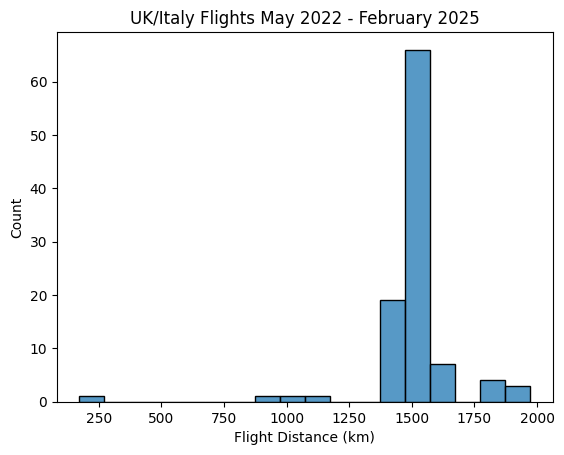

In [31]:
# Extract data for plot title
earliest_flight_date = summary_flight_info_merged3['Flight_Date'].min().strftime('%B %Y')
latest_flight_date = summary_flight_info_merged3['Flight_Date'].max().strftime('%B %Y')

# Plot histogram showing flight distance
fig = sns.histplot(data=summary_flight_info_merged3, x='Distance', binwidth=100)
plt.title(f'UK/Italy Flights {earliest_flight_date} - {latest_flight_date}')
plt.xlabel('Flight Distance (km)')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


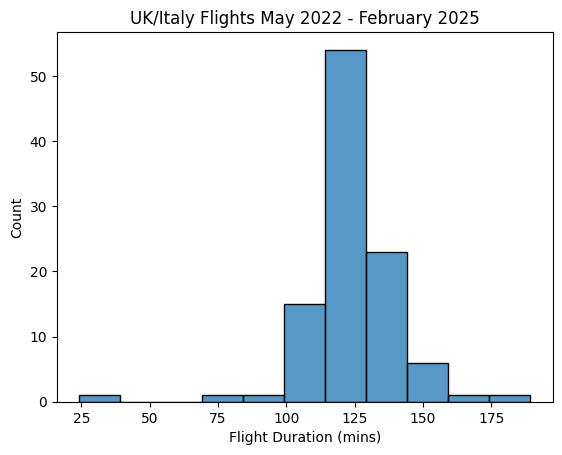

In [32]:
# Convert Flight Duration to minutes
summary_flight_info_merged3['Flight_Duration_mins'] = summary_flight_info_merged3['Flight_Duration'].dt.total_seconds() / 60

# Plot histogram showing flight duration
fig = sns.histplot(data=summary_flight_info_merged3, x='Flight_Duration_mins', binwidth=15)
plt.title(f'UK/Italy Flights {earliest_flight_date} - {latest_flight_date}')
plt.xlabel('Flight Duration (mins)')
plt.show()

The majority of flights average 2 hour duration and 1,500km however we note that there are some outliers.

###  Flight Routes
To investigate the distribution in flight duration and distance, we compile a table of departure and arrival airports.

In [33]:
flight_routes = summary_flight_info_merged3[['Departure_Airport', 'Arrival_Airport', 'Flight_Duration_mins', 'Distance']].groupby(['Departure_Airport', 'Arrival_Airport']).mean().round(1)
flight_routes.head(10)


Flight_Duration_mins  \
Departure_Airport                                  Arrival_Airport                                                            
Bari Karol Wojtyła Airport                         London Gatwick Airport                                             160.5   
Brindisi Airport                                   London Gatwick Airport                                             144.6   
                                                   Milano Linate Airport                                               75.8   
London Gatwick Airport                             Bari Karol Wojtyła Airport                                         141.7   
                                                   Brindisi Airport                                                   147.1   
                                                   Rome–Fiumicino Leonardo da Vinci International ...                 117.5   
London Luton Airport                               London Gatwick Airport                                              24.3   
Milano Linate Airport                              London City Airport                                                 89.5   
Rome–Fiumicino Leonardo da Vinci International ... Charles de Gaulle International Airport                            105.1   
                                                   London Gatwick Airport                                             130.7   

                                                                                                       Distance  
Departure_Airport                                  Arrival_Airport                                               
Bari Karol Wojtyła Airport                         London Gatwick Airport                                1906.1  
Brindisi Airport                                   London Gatwick Airport                                1854.5  
                                                   Milano Linate Airport                                  897.8  
London Gatwick Airport                             Bari Karol Wojtyła Airport                            1803.6  
                                                   Brindisi Airport                                      1923.2  
                                                   Rome–Fiumicino Leonardo da Vinci International ...    1499.4  
London Luton Airport                               London Gatwick Airport                                 173.0  
Milano Linate Airport                              London City Airport                                   1033.3  
Rome–Fiumicino Leonardo da Vinci International ... Charles de Gaulle International Airport               1132.5  
                                                   London Gatwick Airport                                1504.6

We plot the flight tracking data onto a map.

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


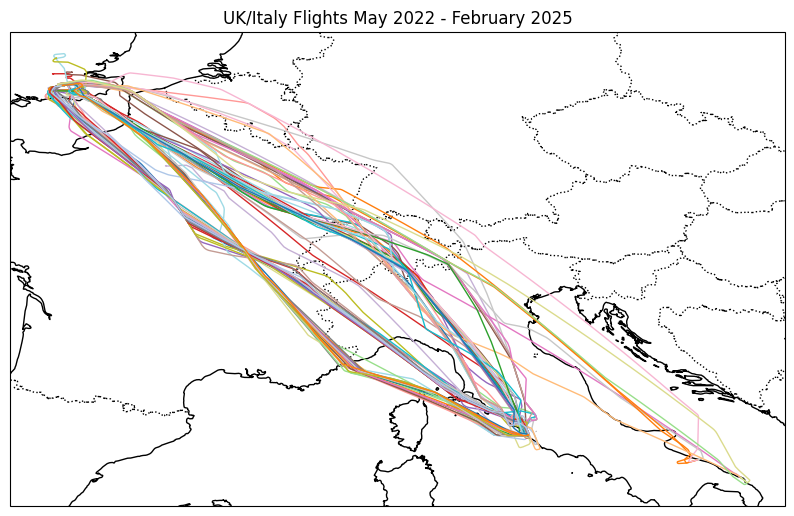

<Figure size 640x480 with 0 Axes>

In [34]:
# Import additional packages
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.cm as cm

# Create list of flight refs
flight_ref_list = summary_flight_info_merged3['Source_File'].tolist()

# Create a figure and an axis with cartopy's PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Set up the map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

# Define a colormap using the updated method
cmap = plt.colormaps['tab20']

# Loop through each flight
for idx, ref in enumerate(flight_ref_list):
    # Filter data for the current flight
    flight_data = subset_df[subset_df['Source_File'] == ref]
    
    # Check if flight data is not empty
    if not flight_data.empty:
        # Select a color based on the index
        color = cmap(idx % 20)
    
        # Plot the flight path (connecting the coordinates)
        ax.plot(flight_data['Longitude'], flight_data['Latitude'], marker='o', color=color, markersize=0, linewidth=1)

# Display the map
plt.title(f'UK/Italy Flights {earliest_flight_date} - {latest_flight_date}')
plt.show()

# Save the map as a PNG file
plt.savefig('flight_paths.png', dpi=300, bbox_inches='tight')

The outliers shown in the histogram correspond to infrequent routes (eg. Luton - Gatwick, Gatwick - Brindisi).

### Flights Totals
We compile statistics summarising the flight journeys.

In [35]:
# Compute flight totals
total_flights = len(summary_flight_info_merged3)
total_distance = summary_flight_info_merged3['Distance'].sum().round(1)
total_duration = summary_flight_info_merged3['Flight_Duration'].sum()
days = total_duration.components.days
hours = total_duration.components.hours
minutes = total_duration.components.minutes
total_hours = days*24 + hours
total_days = round(float(total_hours) / 24, 1)
total_months = round(((float(total_hours) *12)/ (24 * 365)), 1)
total_flight_days = summary_flight_info_merged3['Flight_Date'].nunique()
total_flight_months = round(total_flight_days*12/365, 1)
total_co2_tons = (summary_flight_info_merged3['CO2_Emissions'].sum() / 1000).round(1)

# Show calculation results
print('\nSummary of Flights to Italy      ', f'{earliest_flight_date} - {latest_flight_date}')
print('\nTotal number of flights:         ', total_flights)
print('\nTotal distance travelled:        ', int(total_distance), 'km')
print('                                 ', (total_distance / 40075).round(1), 'times around Earth')
print('                                 ', (total_distance / 384400).round(2), 'times to the Moon')
print('\nTotal time airborne:             ', f'{int(total_hours)} h {int(minutes)} min')
print('                                 ', f'{total_days} days')
print('                                 ', f'{total_months} months')
print('\nTotal number of days travelling: ', f'{total_flight_days} days')
print('                                 ', f'{total_flight_months} months')
print('\nTotal CO2:                       ', f'{(total_co2_tons)} tons')



Summary of Flights to Italy       May 2022 - February 2025

Total number of flights:          103

Total distance travelled:         154595 km
                                  3.9 times around Earth
                                  0.4 times to the Moon

Total time airborne:              212 h 34 min
                                  8.8 days
                                  0.3 months

Total number of days travelling:  93 days
                                  3.1 months

Total CO2:                        14.7 tons


### Output
We output the two DataFrames as CSV files for further visualisation in [Tableau](https://public.tableau.com/views/FlightstoItaly/Dashboard1).

In [36]:
# Save to a new CSV file
subset_df.to_csv('combined_flight_data.csv', index=False)
summary_flight_info_merged3.to_csv('summary_flight_info.csv', index=False)